# Exploration_5
## My First Kaggle-house price prediction

### 1. 데이터 탐색
#### 1.1 문제정의 
* 주어진 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제입니다.
* 평가로는 RMSE를 사용합니다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import os
from os.path import join

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') # 테스트, 즉 submission시 사용할 데이터 경로

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(df_train.shape))
print('test data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


* train : test = 5 : 2로 심하게 불균등하지는 않습니다. 변수가 20개로 적은편이어서 적절한 전처리가 모델성능에 관건이 될 것이라 생각합니다. 

#### 1.2 변수 설명

변수 | 의미
----|----
id | 집을 구분하는 번호
date | 집을 구매한 날짜
price | 타겟 변수인 집의 가격
bedrooms | 침실의 수
bathrooms | 침실당 화장실 개수
sqft_living | 주거 공간의 평당 피트
sqft_lot | 부지의 평당 피트
floors | 집의 층수
waterfront | 집의 전방에 강이 흐르는지 유무(a.k.a. 리버뷰)
view | 집이 얼마나 좋아 보이는지의 정도
condition | 집의 전반적인 상태
grade | King County grading 시스템 기준으로 매긴 집의 등급
sqft_above | 지하실을 제외한 평방 피트
sqft_basement | 지하실의 평방 피트
yr_built | 집을 지은 년도
yr_renovated | 집을 재건축한 년도
zipcode | 우편번호
lat | 위도
long | 경도
sqft_living15 | 근처 15 가구의 주거 공간, 평방 피트
sqft_lot15 | 근처 15가구의 부지, 평방 피트

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

* date column의 type이 object이므로, 학습을 위해 뒤에 나올 전처리 단계에서 정수형(integer)으로 변환해야합니다.

In [5]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
df_test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### bathrooms 값에 소수점의 의미?
* full bath : 화장실, 세면대, 샤워실, 욕조
* 3/4 bath : 화장실, 세면대, 샤워실
* half bath : 화장실, 세면대
* 미국에서는 보통 위와 같이 bathroom을 구분한다고 하네요.

#### 1.3 변수 시각화 (목적변수)
* 목적변수 price의 경우 집을 구매한 시점의 가격입니다. 이 말은 현재의 가격을 반영하는게 아니라는 말과 같습니다. 집을 산 이후 리모델링을 통해 집을 고쳤어도 집의 가격에는 영향을 주지 못합니다.

In [7]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

* 목적변수의 경우 min과 max의 차이가 크고, std가 굉장히 큰 편입니다. 아래의 그림을 보면 더 명확하겠지만 왼쪽으로 분포가 굉장히 치우친 것을 알 수 있습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

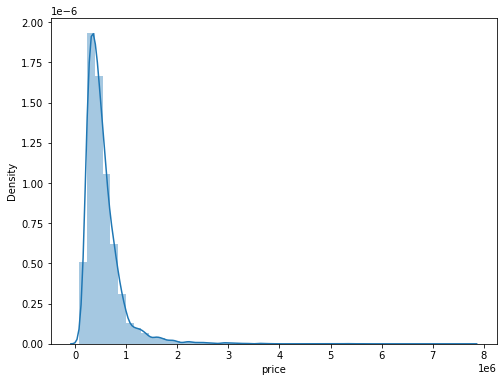

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [9]:
print('Skewness: %f' % df_train['price'].skew())
print('Kurtosis: %f' % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


* 왜도 : 오른쪽 꼬리가 길수록 값이 커집니다.
* 첨도 : 첨도 값(K)이 3에 가까울 경우, scatter는 정규 분포에 가깝습니다. (K<3)이면 분포가 정규 분포보다 더 평탄하다고 판단할 수 있으며, (K>3)이면 분포가 보다 뾰족하다고 판단할 수 있습니다.
---
* 위의 목적변수의 경우 왜도와 첨도가 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. 회귀모델을 사용할 것이기 때문에 정규화를 통해 price의 분포가 정규분포를 가지도록 만들어 주겠습니다.

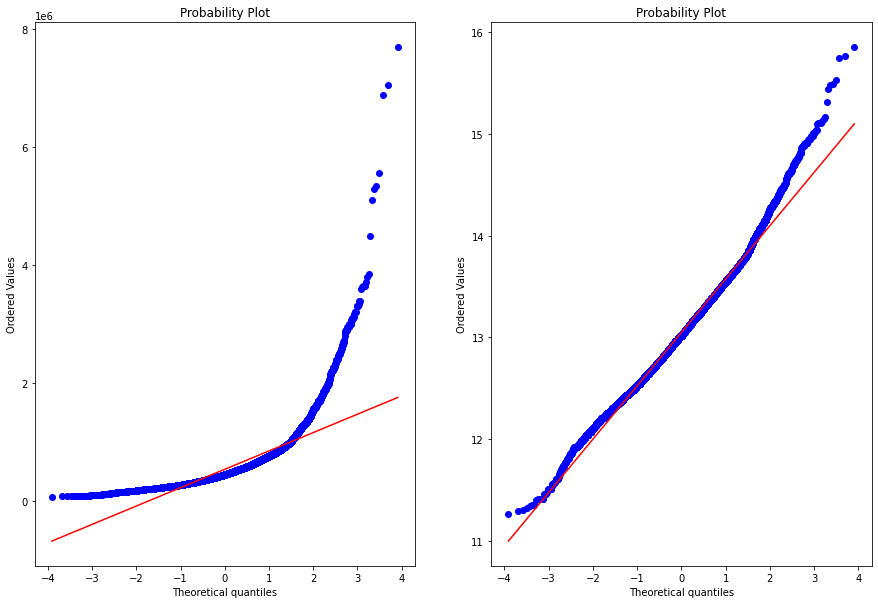

In [10]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

* log 변환을 해주면 기존보다 더 정규성을 가지는 것을 확인할 수 있습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

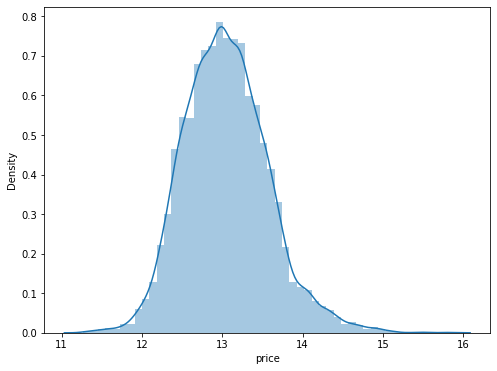

In [11]:
df_train['price'] = np.log1p(df_train['price'])

f, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_train['price'])

#### 1.3 변수 시각화 (반응변수)
* 피어슨 상관계수 : 연속형 변수에 사용
* 스피어만 순위 상관관계 : 번주형 변수도 포함되었을 경우에 사용
---
* 아래는 목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다. 전부 보는 것이 아니라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 하겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

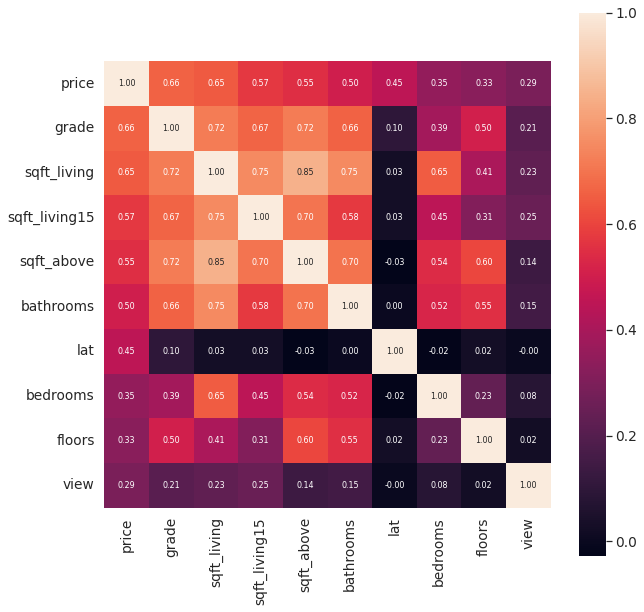

In [12]:
# correlation이 높은 상위 10개의 heatmap
# continuous & sequential variables -> spearman
# abs는 반비례관계도 고려하기 위함

import scipy as sp

cor_abs = abs(df_train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index
# price와의 correlation이 높은 column 10객 뽑기(내림차순)
# spearman coefficint matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10x10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, 
            annot_kws={'size' : 8}, xticklabels=cor_cols.values,
           yticklabels=cor_cols.values)

* 목적변수와 상관도가 높은 변수는 집의 등급, 주거공간의 크기, 전체 크기순이고 흥미롭게도 lat이라는 위도 값이 들어있습니다. 위도가 증가함에 따라 가격이 증가하는 이유를 좀 더 탐색할 필요가 있어보입니다. ( -> 위 지역은 시애틀인데 북쪽으로 갈수록 살기 좋은 집들이 많다고 합니다.)

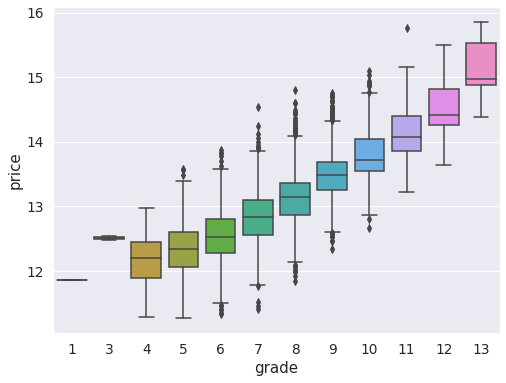

In [13]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade', y='price', data=data)

* grade의 경우 '1,2,3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11,12,13은 높은 수준의 건축 및 디자인을 지니고 있습니다.'라고 합니다.
* 집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전반적으로 상승곡선의 형태도 보이고 있습니다. 하지만,
    * 등급 3의 경우 값이 큰 이유
    * 등급 7,8,9에서 이상치가 많은 이유
    * 등급 8과 11에서 차이가 큰 이상치가 나타나는 이유
* 위의 3가지는 좀 더 자세히 살펴봐야 합니다.

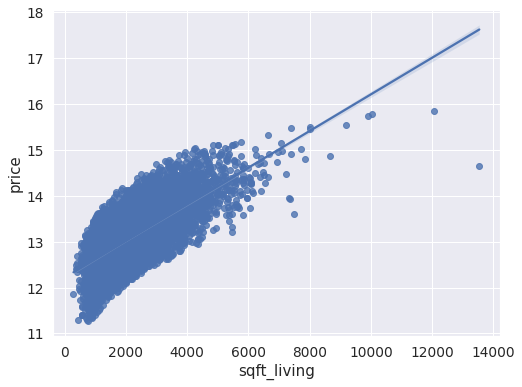

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

* 전반적으로 선형성을 보이지만 가격이 14와 15 사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)이라고 생각합니다. 제거할지 말지는 저 값을 확인해보고 결정하겠습니다.

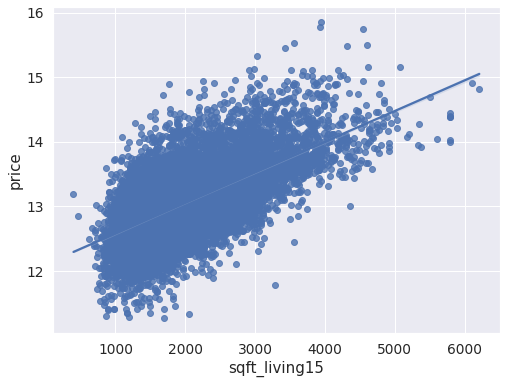

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

* sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다. 아무래도 재건축으로 인한 영향일 것이라고 생각하고 sqft_living15 자체를 사용하기보다는 적절한 FE가 필요해 보입니다.

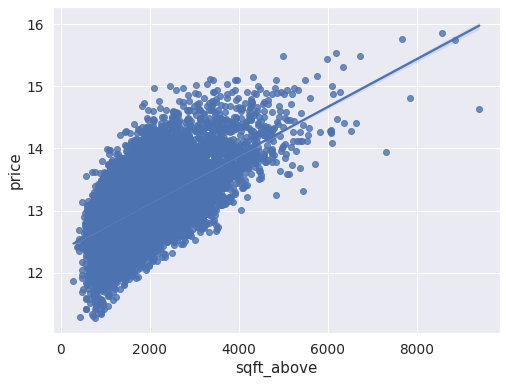

In [16]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

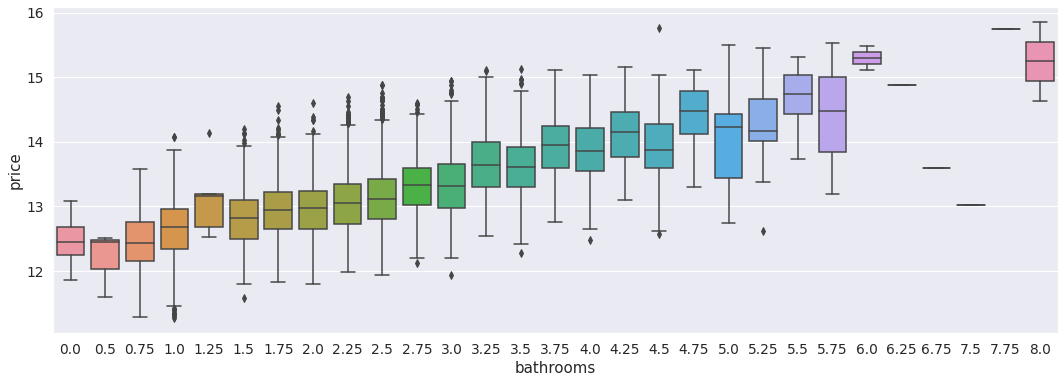

In [17]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18,6))
fig = sns.boxplot(x='bathrooms', y='price', data=data)

* bathrooms의 경우 위에서도 한 번 언급했듯이 소수점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는 것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개 있는지는 구분하기 힘들어 보입니다.
    * 0.5 : 세면대, 화장실
    * 0.75 : 세면대, 화장실, 샤워실
    * 1 : 세면대, 화장실, 샤워실, 욕조

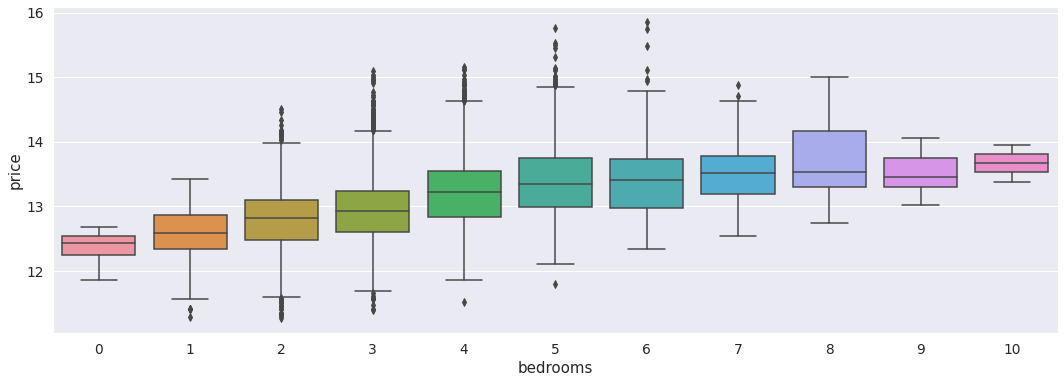

In [18]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18,6))
fig = sns.boxplot(x='bedrooms', y='price', data=data)

* bedrooms의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 보입니다. 그리고 방의 갯수가 2,3,4,5,6의 경우 방이 적음에도 큰 값들이 많습니다. 이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.

#### 1.4 결측치

<AxesSubplot:>

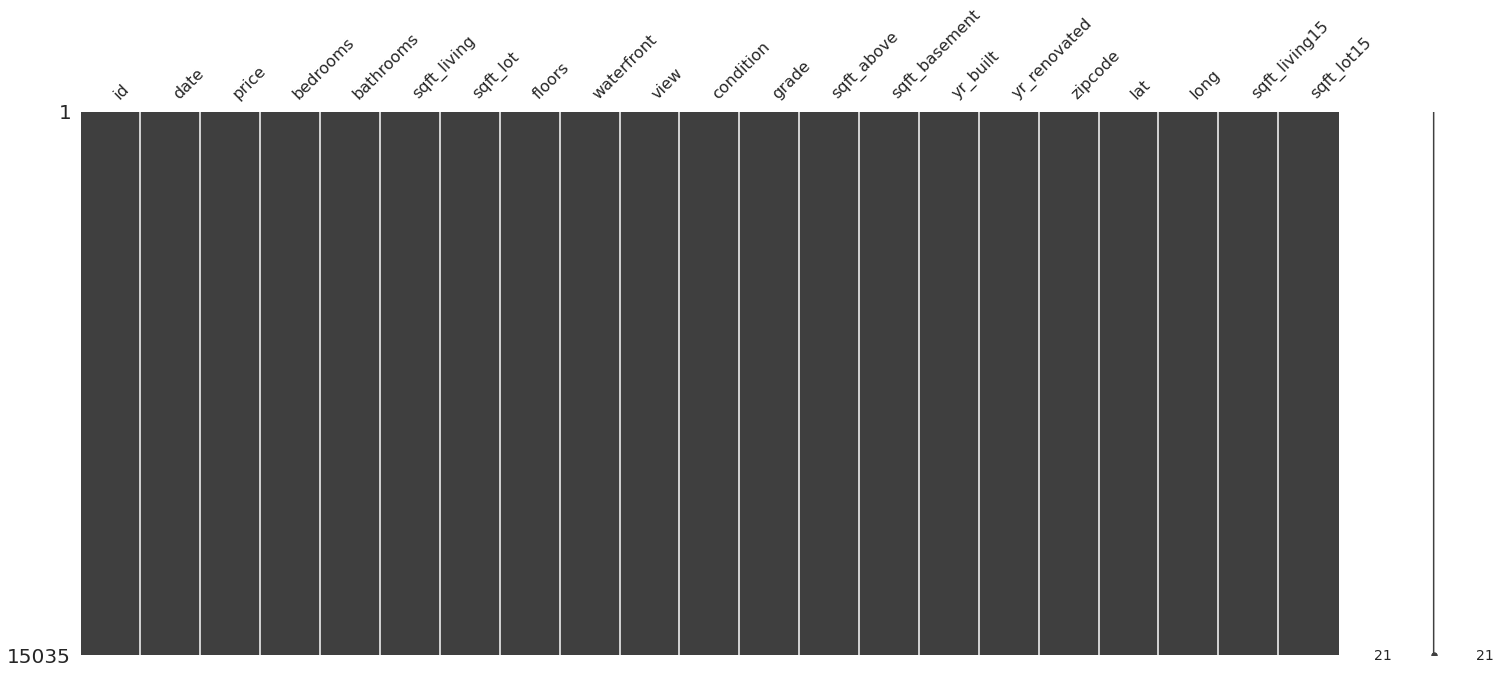

In [19]:
import missingno as msno
msno.matrix(df_train)

<AxesSubplot:>

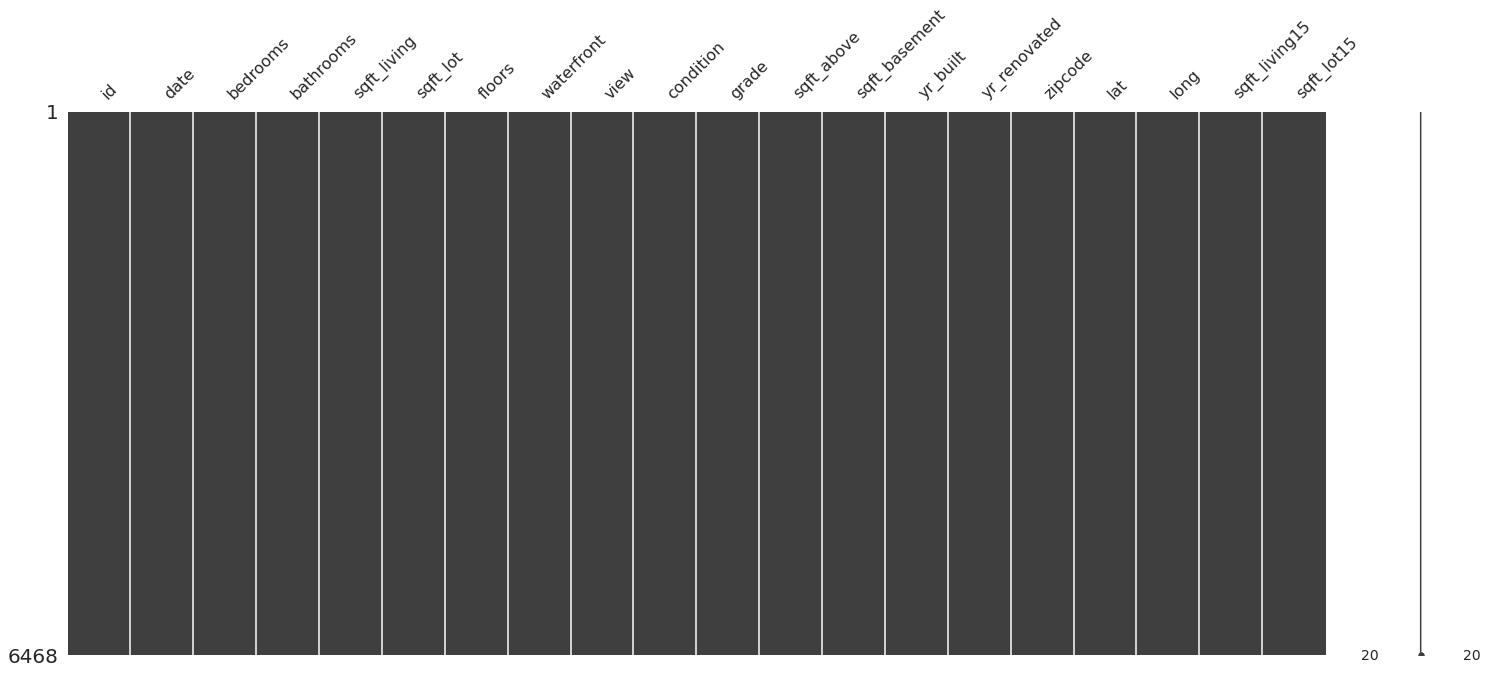

In [20]:
msno.matrix(df_test)

* 다행히도 위의 missingno matrix를 보면 결측치가 없는 상황입니다.

### 2. 데이터 전처리
#### 2.1 이상치 제거
* 위에서 중요한 변수들에 대해 시각화를 해봤을때, 'sqft_living', 'grade', 'bedrooms' 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다.

##### 2.1.1 sqft_living

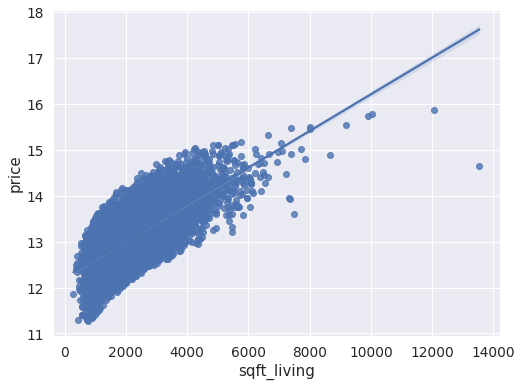

In [21]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [22]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


* 위의 값을 봤을때, 다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다. 추가적으로 price와 상관성이 높은 grade와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 하겠습니다.

In [23]:
df_train = df_train.loc[df_train['id'] != 8990]

##### 2.1.2 grade

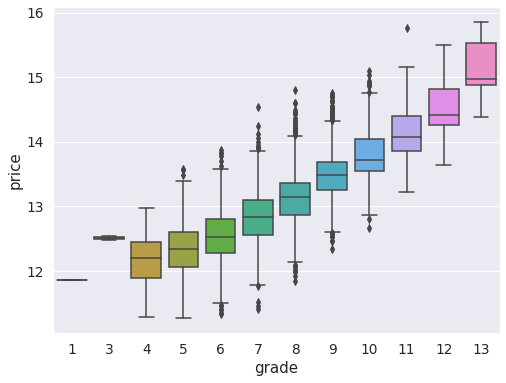

In [24]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade', y='price', data=data)

In [25]:
df_train.loc[(df_train['price'] > 12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


* 가장 중요한 변수인 grade, sqft_모두 낮은 것을 볼 수 있습니다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.

In [26]:
df_train.loc[(df_train['price'] > 15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


* 위의 세 값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.

In [27]:
df_train = df_train.loc[df_train['id'] != 456]
df_train = df_train.loc[df_train['id'] != 2302]
df_train = df_train.loc[df_train['id'] != 4123]
df_train = df_train.loc[df_train['id'] != 7259]
df_train = df_train.loc[df_train['id'] != 2777]

##### 2.1.3 bedrooms

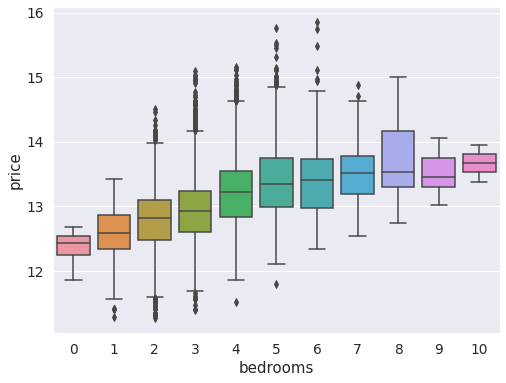

In [28]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='bedrooms', y='price', data=data)

* bedrooms를 보면 위에서 한번 언급했듯이 median이 양의 상관관계를 띄고 있습니다. 그리고 bedrooms가 2,3,4,5,6은 분산이 매우 큰 것을 확인할 수 있습니다. 가운데의 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.

#### 2.2 정규화

In [29]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

#### 2.3 변수 수정

In [30]:
for df in [df_train, df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

### 3. 변수 생성

In [31]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [32]:
for df in [df_train, df_test]:
    # 방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']
    
    # 재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x ==0 else 1)
    df['date'] = df['date'].astype('int')

* 아래 집값 같은 경우, 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다.

In [33]:
df_train['per_price'] = df_train['price'] / df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean', 'var'}).reset_index()
df_train = pd.merge(df_train, zipcode_price, how='left', on='zipcode')
df_test = pd.merge(df_test, zipcode_price, how='left', on='zipcode')

for df in [df_train, df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']
    del df['var']

### 4. 모델링
#### 4.1 단순 선형회귀

In [34]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [35]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id', 'price', 'per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.746e+06
Date:                Mon, 24 Jan 2022   Prob (F-statistic):                        0.00
Time:                        07:01:54   Log-Likelihood:                         -7.7075
No. Observations:               15029   AIC:                                      65.42
Df Residuals:                   15004   BIC:                                      255.9
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

* 모델의 설명력을 보면 1로 굉장히 높지만, 각각의 변수들 중에는 p-value가 높은 값들이 있음을 확인할 수 있습니다. 그렇나 이유를 생각해보면 FE해서 나온 파생변수들은 기존의 변수와 연결되어있고 sqft_로 시작하는 변수들끼리의 상관성이 있어서 다중 공선성의 문제를 가지기 때문입니다. 실제로 다중공선성을 체크하기 위해 vif를 이용한 확인을 하면

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif['Features'] = df_train.columns
vif['VIF Values'] = [variance_inflation_factor(df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values', ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.294167e+06
1,date,4.284045e+06
18,long,2.057338e+06
17,lat,2.441371e+05


* 보통의 경우 10이상이면 다중공선성이 존재한다고 말하는데, 위의 식에서는 waterfront, view, sqft_lot15, is_renovated 4가지 변수를 제외한 모든 변수들에서 다중공선성이 존재하는 문제점이 있습니다.
* 이를 해결하기 위한 방안으로
    * 다중공선성에 robust한 트리모델을 사용하는 방법
    * 변수제거 및 FE, 변화 등을 통한 대체
    * 관측값을 늘려 표본의 크기를 증가
* 하지만 세번째 방안은 실현이 불가능하고 선형회귀를 사용할거면 두번째를 최대한 활용하고, 그렇지 않을 경우에는 첫번째 방안을 사용하면 됩니다.

#### 4.2 LightGBM

In [37]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.140092	valid_1's rmse: 0.156519
[1000]	training's rmse: 0.121221	valid_1's rmse: 0.153075
[1500]	training's rmse: 0.108602	valid_1's rmse: 0.152351
Early stopping, best iteration is:
[1505]	training's rmse: 0.108489	valid_1's rmse: 0.152332
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139304	valid_1's rmse: 0.159886
[1000]	training's rmse: 0.120849	valid_1's rmse: 0.155975
[1500]	training's rmse: 0.108283	valid_1's rmse: 0.154827
[2000]	training's rmse: 0.0982398	valid_1's rmse: 0.154545
Early stopping, best iteration is:
[2130]	training's rmse: 0.0959464	valid_1's rmse: 0.154486
[LightGBM] [Warning] min_data_in_leaf is

In [38]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


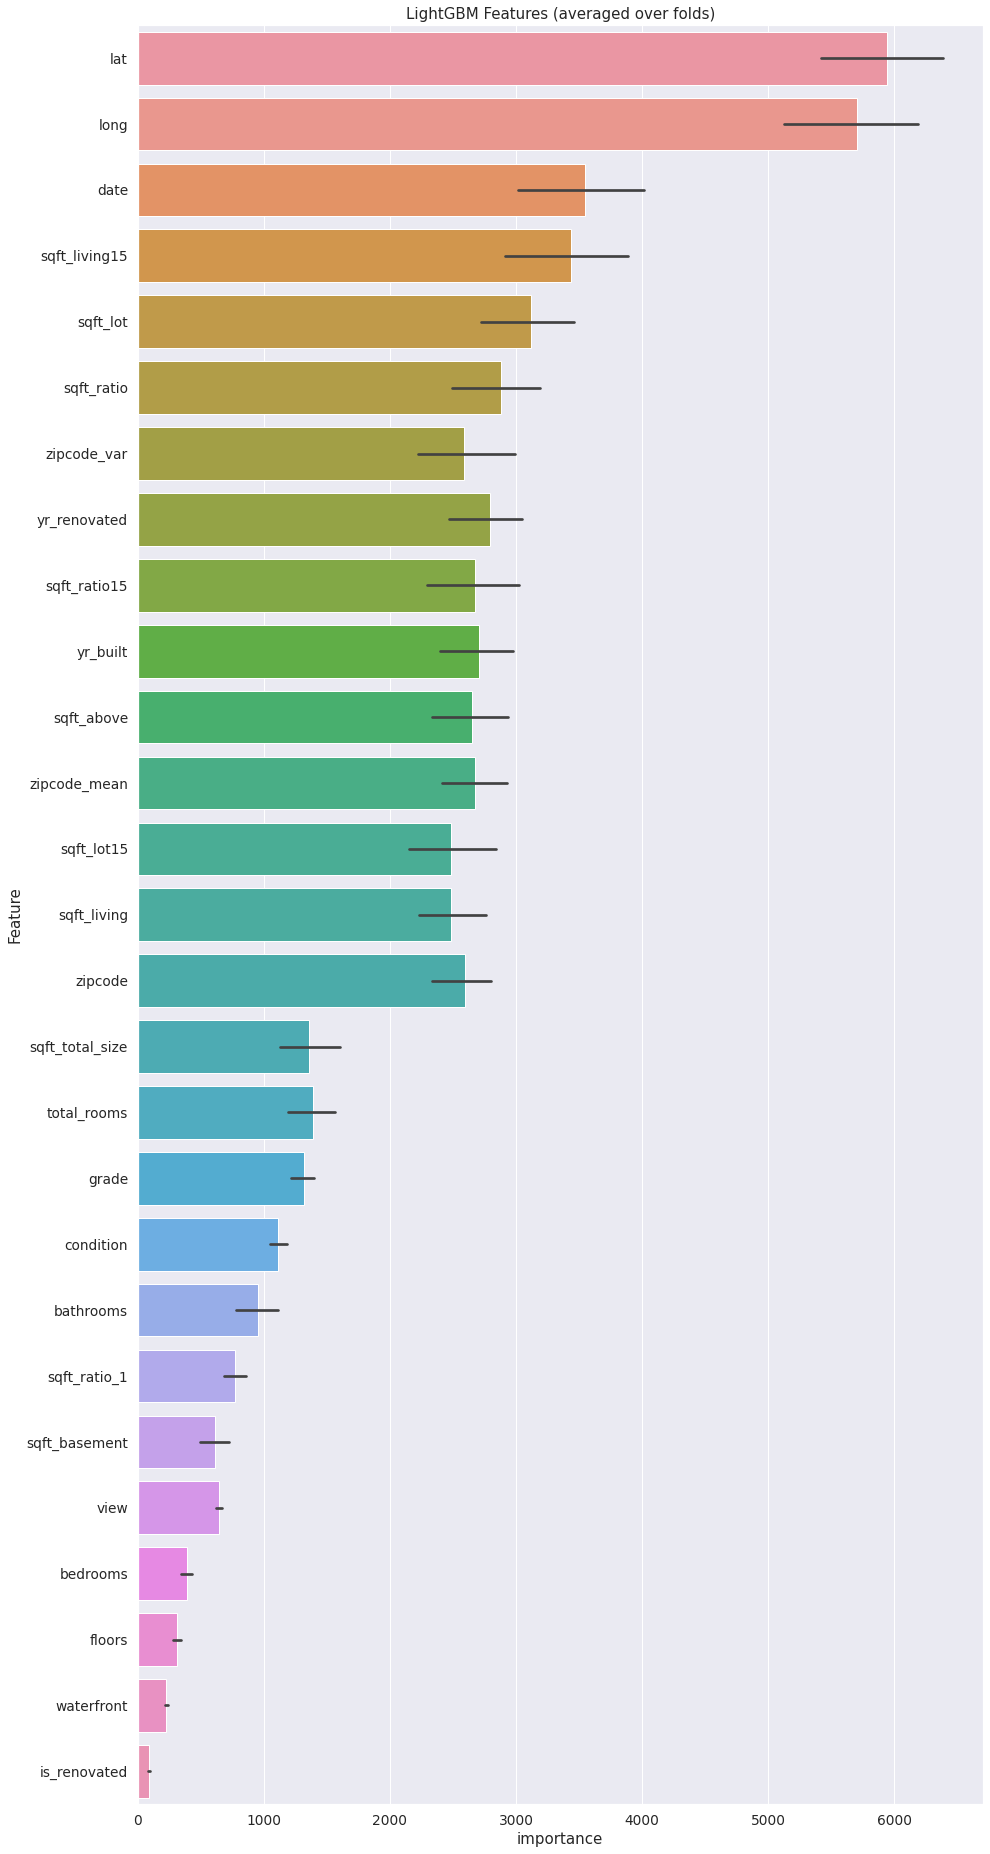

In [39]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

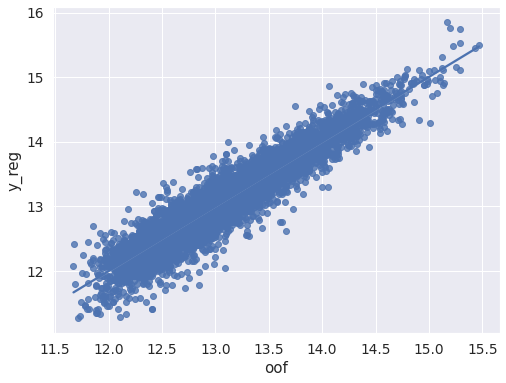

In [40]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof', 'y_reg']
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='oof', y='y_reg', data=data)

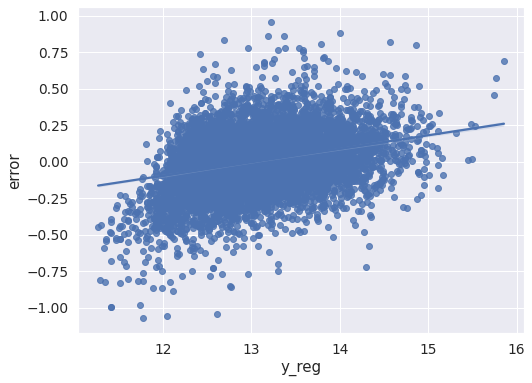

In [41]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof', 'y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='y_reg', y='error', data=data)

* 실제 y_reg와 error와의 관계를 보면 잔차가 독립적이지 않은 것을 볼 수 이습니다. 13과 14 부근에 error가 0에 가깝습니다. 하지만 15이상은 더 높게 예측 하는 경향을 보이고, 12이하는 더 낮게 예측하는 경향을 보입니다.
* 이를 개선하기 위해서는
    * 15이상에서 크게 예측한 이유
    * 12이하에서 작게 예측한 이유
    * error가 0.5이상인 값들의 이유
* 세 가지 관점에서 접근을 해야 합니다.

### Ensemble

In [42]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115960.42942127095


In [43]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135526	valid_1's rmse: 134961
[1000]	training's rmse: 110615	valid_1's rmse: 123725
[1500]	training's rmse: 99530.7	valid_1's rmse: 121525
[2000]	training's rmse: 91409.6	valid_1's rmse: 121040
Early stopping, best iteration is:
[2067]	training's rmse: 90494.9	valid_1's rmse: 120880
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135171	valid_1's rmse: 134731
[1000]	training's rmse: 110537	valid_1's rmse: 117358
[1500]	training's rmse: 100159	valid_1's rmse: 114319
Early stopping, best iteration is:
[1845]	training's rmse: 94511.6	valid_1's rmse: 113898
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will

In [44]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124996.83409814813


In [45]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[07:03:46] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:46] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:03:46] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:46] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:03:46] WARNING: ../src/objective/regression_obj.cu:171:

In [46]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[07:07:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:18] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:07:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:18] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:07:18] WARNING: ../src/objective/regression_obj.cu:171:

In [47]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115824.77593122724


In [48]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [49]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [50]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission.csv",index=False)

## score : 108686

### reference : https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12